To start with the project, we are going to implement some libraries and their functionalities are discussed to an extent in the comments in front of them.

However we can further discuss our choice of libraries and the reasoning behind our choice. 


TensorFlow Sequential : Linear Stack of Layers grouped together to train data. Simplest tensorflow model . 

In [27]:
import numpy as np                                        # Numpy to perform numerical operations with on datasets and also to perform operations on matrices 
import pandas as pd                                       # Pandas to handle and manipulate structured data from the csv files
import matplotlib.pyplot as plt                           # For plotting 
import seaborn as sns
from datetime import datetime           
import yfinance as yf


# To preprocesss and scale our data to feed our machine learning algorithm 
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential            # Simplest tensorflow model  
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.random import set_seed

from pandas_datareader.data import DataReader

import warnings
warnings.simplefilter("ignore")

set_seed(455)
np.random.seed(455)

In [76]:
end = datetime.now()
start = datetime(2015, end.month, end.day)
brand = "GOOG"
dataset = yf.download(brand, start, end)

[*********************100%%**********************]  1 of 1 completed


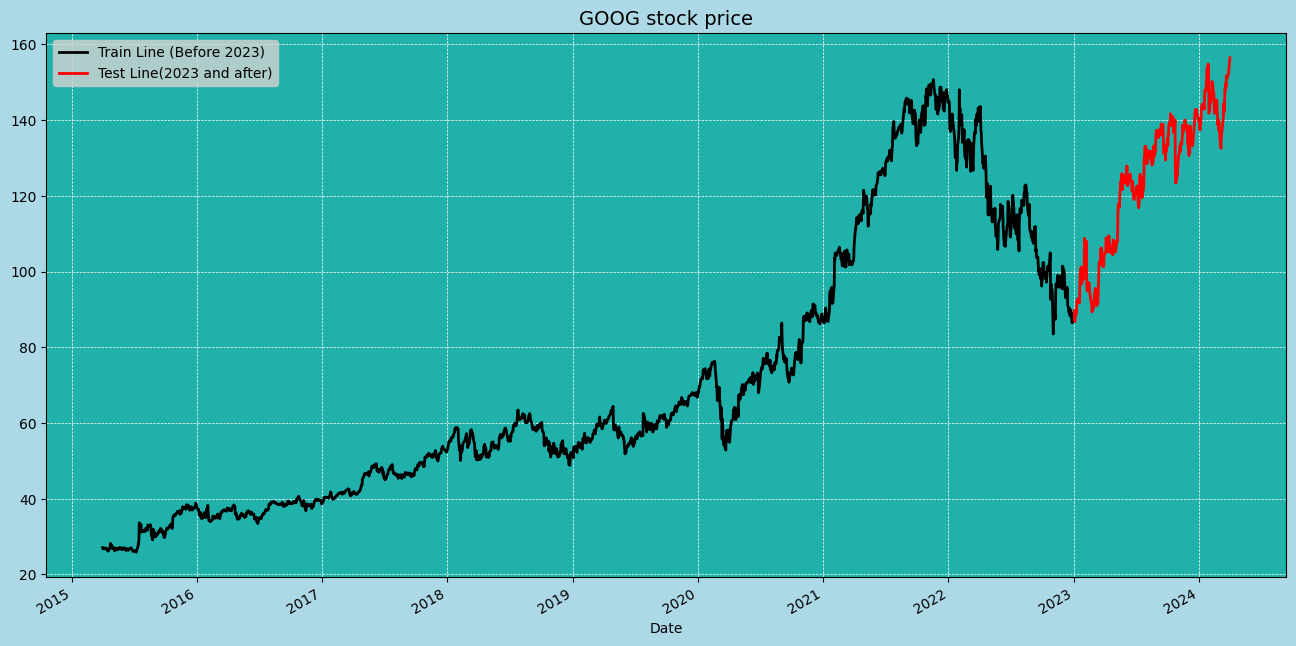

In [77]:
tstart = 2014
tend = 2022

def train_test_plot(dataset, tstart, tend):

    fig = plt.figure(figsize=(16, 8), facecolor='lightblue')
    ax = fig.add_subplot(111)
    ax.set_facecolor('lightseagreen')
    dataset.loc[f"{tstart}":f"{tend}", "Close"].plot(ax=ax, color='black', linewidth=2, legend=True, label=f"Train Line (Before {tend+1})")
    dataset.loc[f"{tend+1}":, "Close"].plot(ax=ax, color='red', linewidth=2, legend=True, label=f"Test Line({tend+1} and after)")
    leg = plt.legend(facecolor='lightgrey')
    
    for text in leg.get_texts():
        text.set_color('black')

    plt.title(f"{brand} stock price", color='black', fontsize=14)
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

    
    plt.show()

    
train_test_plot(dataset,tstart,tend)

In [88]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "Close"]
    test = dataset.loc[f"{tend+1}":, "Close"]
    return train.values, test.values

training_set, test_set = train_test_split(dataset, tstart, tend)

training_set


array([27.05372429, 26.70318604, 26.76476669, ..., 86.45999908,
       88.94999695, 88.73000336])

Now that we have the training and testing data split into two, we are going to convert our data to a format suitable for learning by creating sequences of observation as input and subsequent observations as output. It is a common preparation step in time series forecasting when using neural networks. 

MinMax Scaler is called to scale data to range 0 to 1. Normalizing it this way makes it easier for our GRU ( talked about later) to perform better with inputs in this range. It expects a 2D array to work with . 



In [89]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))                         #scale data to range of 0 to 1
training_set = training_set.reshape(-1, 1)                      #Reshape training dataset to 2D array with a single feature 
training_set_scaled = sc.fit_transform(training_set)            #scales the training data's array and transforms it

training_set

array([[27.05372429],
       [26.70318604],
       [26.76476669],
       ...,
       [86.45999908],
       [88.94999695],
       [88.73000336]])

In [90]:

def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [91]:
'''model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary() '''

model_gru = Sequential([
    GRU(units=125, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Dropout for regularization
    GRU(units=125),  # Additional GRU layer
    Dropout(0.2),  # Additional dropout layer for regularization
    Dense(units=1)
])


optimizer = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='mse')

In [92]:
dataset_total = dataset.loc[:,"Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [93]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test) 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [94]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0464 - val_loss: 0.0033
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0020 - val_loss: 8.6729e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9.9698e-04 - val_loss: 9.5315e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 9.8137e-04 - val_loss: 9.6082e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9.3602e-04 - val_loss: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0010 - val_loss: 9.0874e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 9.4219e-04 - val_loss: 7.7115e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.8742e-04 - val_loss: 8.8782e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.8066e-04 - val_loss: 7.7419e-04
Epoch 12/50

In [ ]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


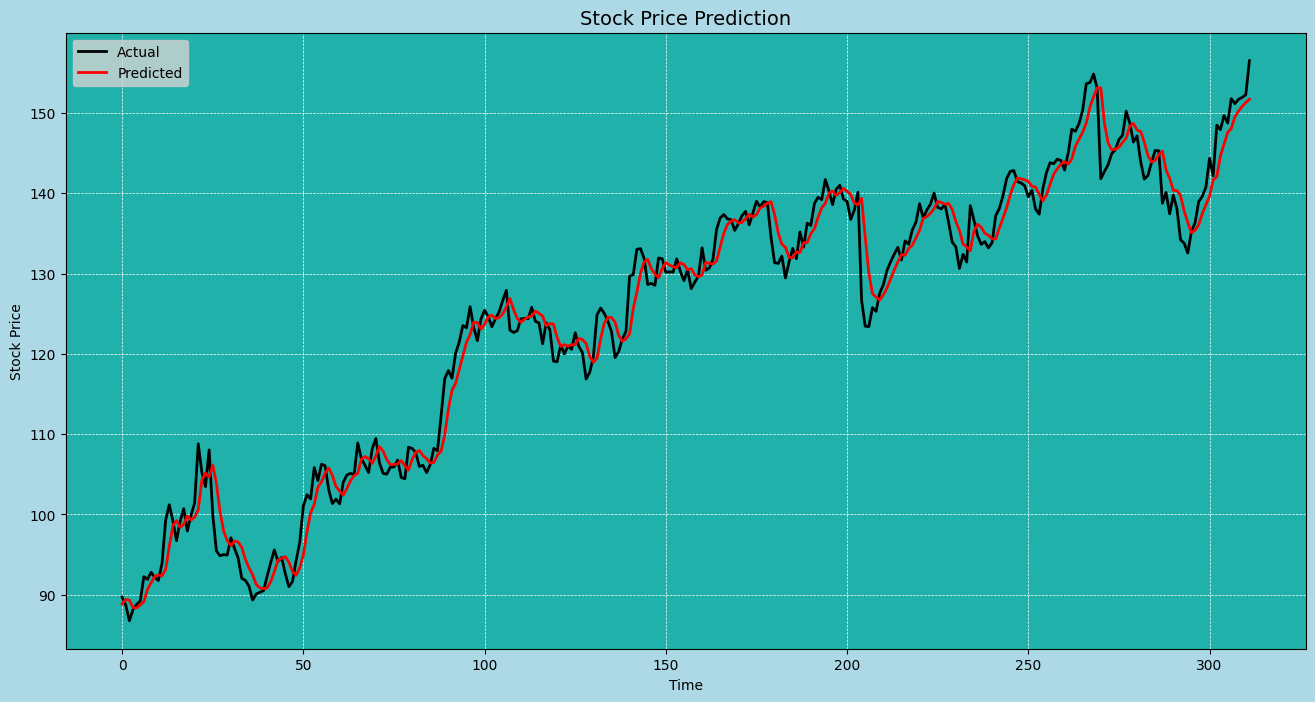

In [ ]:
def plot_predictions(test, predicted):
    import matplotlib.pyplot as plt

    
    fig = plt.figure(figsize=(16, 8), facecolor='lightblue')
    
    ax = fig.add_subplot(111)
    ax.set_facecolor('lightseagreen')
    ax.plot(test, color='black', linewidth=2, label="Actual")
    ax.plot(predicted, color='red', linewidth=2, label="Predicted")
    leg = plt.legend(facecolor='lightgrey')

    for text in leg.get_texts():
        text.set_color('black')

    plt.title("Stock Price Prediction", color='black', fontsize=14)
    plt.xlabel("Time", color='black', fontsize=10)
    plt.ylabel("Stock Price", color='black', fontsize=10)
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

    # Show the plot
plt.show()



def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


    
plot_predictions(y_test,GRU_predicted_stock_price)

In [ ]:
return_rmse(y_test, GRU_predicted_stock_price)

The root mean squared error is 2.82.
